In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from re import search
import natsort
from PIL import Image
from tqdm import tqdm
import shutil
import tensorflow as tf
import cv2

In [40]:
DIR = r'D:\plant-pathology-2020-fgvc7\images'

In [41]:
train = pd.read_csv(r'D:\plant-pathology-2020-fgvc7\train.csv')

In [42]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [43]:
test = pd.read_csv(r'D:\plant-pathology-2020-fgvc7\test.csv')

In [44]:
test.head(5)

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


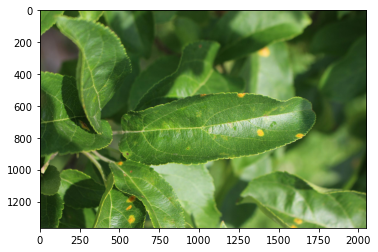

In [45]:
image = Image.open(r'D:\plant-pathology-2020-fgvc7\images\Test_0.jpg')
plt.imshow(image)
plt.show()

In [46]:
class_name =  train.iloc[: , 1:].columns
class_name

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [47]:
number = 0
train['label'] = 0
for i in class_name:
    train['label']= train['label'] + train[i] * number
    number +=1

In [48]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [167]:
def get_label_img(img):
    if search('Train',img):
        img = img.split('.')[0]
        label = train.loc[train['image_id']== img]['label']
        return label

In [168]:
def create_train_data():
    image  = natsort.natsorted(os.listdir(DIR))
    for img in tqdm(image):
        label = get_label_img(img)
        path = os.path.join(DIR,img)
        
        if search('Train',img):
            if (img.split('_')[1].split('.')[0]) and label.item()==0:
                shutil.copy(path,r'D:\plant-pathology-2020-fgvc7\train\healthy')
            elif (img.split('_')[1].split('.')[0]) and label.item()==1:
                shutil.copy(path,r'D:\plant-pathology-2020-fgvc7\train\multipledisease')
            elif (img.split('_')[1].split('.')[0]) and label.item()==2:
                shutil.copy(path,r'D:\plant-pathology-2020-fgvc7\train\rust')
            elif (img.split('_')[1].split('.')[0]) and label.item()==3:
                shutil.copy(path,r'D:\plant-pathology-2020-fgvc7\train\scab')
        elif search('Test',img):
            shutil.copy(path,r'D:\plant-pathology-2020-fgvc7\test')

In [54]:
# os.mkdir(r'D:\plant-pathology-2020-fgvc7\train')
os.mkdir(r'D:\plant-pathology-2020-fgvc7\train\healthy')
os.mkdir(r'D:\plant-pathology-2020-fgvc7\train\multipledisease')
os.mkdir(r'D:\plant-pathology-2020-fgvc7\train\rust')
os.mkdir(r'D:\plant-pathology-2020-fgvc7\train\scab')
os.mkdir(r'D:\plant-pathology-2020-fgvc7\test')

In [72]:
train_dir = create_train_data()

100%|██████████████████████████████████████████████████████████████████████████████| 3642/3642 [01:06<00:00, 55.08it/s]


# Data Processing

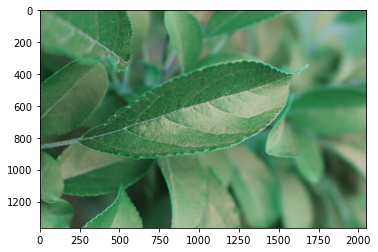

In [74]:
Train_DIR = r'D:\plant-pathology-2020-fgvc7\train'
catagories = ['healthy', 'multipledisease','rust','scab']

for j in catagories:
    path = os.path.join(Train_DIR,j)
    for img in os.listdir(path):
        old_image = cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break

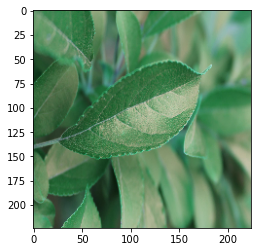

In [76]:
Img_size = 224   #random size to reduce the size of image
new_image = cv2.resize(old_image,(Img_size,Img_size))
plt.imshow(new_image)
plt.show()


# Model Prepration

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense , Activation , Dropout , Flatten, BatchNormalization , Conv2D , MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
# import data_generator as datagen

In [204]:
datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip= True,
                                   vertical_flip= True,
                                   validation_split=0.2)

train_datagen = datagen.flow_from_directory(r'D:\plant-pathology-2020-fgvc7\train',
                                           target_size=(Img_size,Img_size),
                                           batch_size = 8,
                                           class_mode='categorical',
                                           subset='training')
val_datagen =datagen.flow_from_directory(r'D:\plant-pathology-2020-fgvc7\train',
                                           target_size=(Img_size,Img_size),
                                           batch_size = 8,
                                           class_mode='categorical',
                                           subset='validation')

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


In [205]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation = 'relu',padding='same',input_shape=(Img_size,Img_size,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation = 'relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation = 'relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation = 'relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(4 , activation ='softmax'))

# compile model
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 128)     

In [206]:
checkpoint = ModelCheckpoint(r'D:\plant-pathology-2020-fgvc7\model\apple4.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=10,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [checkpoint,earlystop]

In [207]:
model_history = model.fit_generator(train_datagen, validation_data = val_datagen,
                             epochs=30,
                             steps_per_epoch= train_datagen.samples//8,
                             validation_steps = val_datagen.samples//8,
                             callbacks = callbacks)

Epoch 1/30
182/182 [==============================] - 119s 653ms/step - loss: 1.2637 - accuracy: 0.3399 - val_loss: 1.2391 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 1.23908, saving model to D:\plant-pathology-2020-fgvc7\model\apple4.h5
Epoch 2/30
182/182 [==============================] - 116s 640ms/step - loss: 1.2351 - accuracy: 0.3564 - val_loss: 1.2045 - val_accuracy: 0.4278

Epoch 00002: val_loss improved from 1.23908 to 1.20446, saving model to D:\plant-pathology-2020-fgvc7\model\apple4.h5
Epoch 3/30
182/182 [==============================] - 127s 699ms/step - loss: 1.1878 - accuracy: 0.4476 - val_loss: 1.1441 - val_accuracy: 0.5167

Epoch 00003: val_loss improved from 1.20446 to 1.14405, saving model to D:\plant-pathology-2020-fgvc7\model\apple4.h5
Epoch 4/30
182/182 [==============================] - 128s 705ms/step - loss: 1.1588 - accuracy: 0.5158 - val_loss: 1.0530 - val_accuracy: 0.6056

Epoch 00004: val_loss improved from 1.14405 to 1.05296, saving

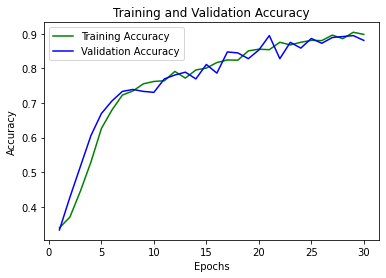

In [208]:
acc_train = model_history.history['accuracy']
acc_val = model_history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs,acc_train , 'g',label = 'Training Accuracy')
plt.plot(epochs,acc_val , 'b',label = 'Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

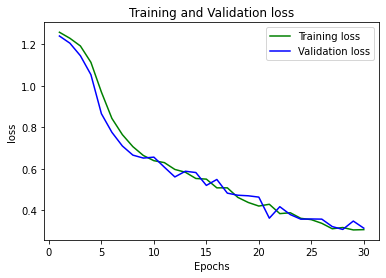

In [209]:
loss_train = model_history.history['loss']
loss_val = model_history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs,loss_train, 'g',label = 'Training loss')
plt.plot(epochs,loss_val, 'b',label = 'Validation loss')
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# Making the Prediction on a Single Image

0


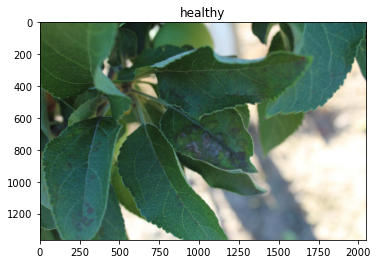

In [210]:
test_image = r'D:\plant-pathology-2020-fgvc7\test\Test_184.jpg'
image_result = Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image = image.load_img(test_image , target_size=(224,224))
test_image = image.img_to_array(test_image)
test_image = test_image/255
test_image=np.expand_dims(test_image,axis=0)
result = model.predict(test_image)
print(np.argmax(result))
Categories = ['healthy','multiple_disease','rust','scab']
image_result = plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
DIIR = r'D:\plant-pathology-2020-fgvc7\test'
path = os.listdir(DIIR)
for i in path:
    img = os.path.join(DIIR,i)
    iimg = Image.open(img)
    test_image = image.load_img(img , target_size=(224,224))
    test_image = image.img_to_array(test_image)
    test_image = test_image/255
    test_image=np.expand_dims(test_image,axis=0)
    result = model.predict(test_image)
    Categories = ['healthy','multiple_disease','rust','scab']
#     print(np.argmax(result))
    im = i.split('.')[0]
    C = Categories[np.argmax(result)]
#     print(C)
    plt.imshow(iimg)
    iimg = iimg.save(r'D:\plant-pathology-2020-fgvc7\predicted\\'+im+'__'+C+'.jpg')
#     plt.show()